# Naive Bayes Multiclass Classification


In [1]:
import pandas as pd
import numpy as np
import shap

import os
from os.path import dirname, join
from pathlib import Path

from sklearn.naive_bayes import GaussianNB  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [2]:
def File_path(foldername,filename):
    ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
    data_PATH = join(ROOT_DIR[:-16],foldername,filename)  # requires `import os`
    return data_PATH
# Merging two lists with unique values in return
def dMerger(l1,l2):
    container = []
    container = l1.copy()
    for data in l2:
        if data not in container:
            container.append(data)
    return container 

# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
# colUniq(data_tier2)

# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

## Loading Train, Val, Test

In [3]:
data_cleaned = pd.read_csv(File_path('Train_Test_Val','data_cleaned.csv'))

X_train_train = pd.read_csv(File_path('Train_Test_Val','X_train_train.csv'))
y_train_train = pd.read_csv(File_path('Train_Test_Val','y_train_train.csv'))

X_train_val = pd.read_csv(File_path('Train_Test_Val','X_train_val.csv'))
y_train_val = pd.read_csv(File_path('Train_Test_Val','y_train_val.csv'))

X_test_test = pd.read_csv(File_path('Train_Test_Val','X_test.csv'))
y_test_test = pd.read_csv(File_path('Train_Test_Val','y_test.csv'))


In [4]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [5]:
print('X_Train')
print(X_train_train.info())
print('\n')
print('y_Train')
print(y_train_train['type_cleaned'].unique(),len(y_train_val))
print('\n')
print('X_val')
print(X_train_val.info())
print('\n')
print('y_val')
print(y_train_val['type_cleaned'].unique(), len(y_train_val))

X_Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27106 entries, 0 to 27105
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 21.5 MB
None


y_Train
['Closet' 'Bedroom' 'Room' 'Storage' 'Outdoor' 'Kitchen' 'Dining' 'Bath'
 'LivingRoom' 'Entry' 'Utility' 'Garage' 'CarPort'] 6777


X_val
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777 entries, 0 to 6776
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 5.4 MB
None


y_val
['Outdoor' 'Dining' 'Bedroom' 'Entry' 'Bath' 'Room' 'LivingRoom' 'Kitchen'
 'Closet' 'Utility' 'Storage' 'Garage' 'CarPort'] 6777


## Creating Feature Groups

In [6]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = []
tier_spc = []
tier_con = []
for col in X_train_train.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)

tier_2a = dMerger(tier_spc,tier_con)
tier_2b = dMerger(tier_spc,tier_fur)

col_select = {
    'fur' : tier_fur,
    'con' : tier_con,
    'spc' : tier_spc,
    'spc_con' : tier_2a,
    'spc_fur' : tier_2b 
            } 


In [7]:
len_spc = len(col_select['spc'])
len_con = len(col_select['con'])
len_fur = len(col_select['fur'])
print('fur:',len_fur,'con:',len_con,'spc:',len_spc)
print('total features:',sum([len_fur,len_con,len_spc]), 'Should be:',len(X_train_train.columns))

fur: 32 con: 58 spc: 14
total features: 104 Should be: 104


### Defining Paths

In [8]:
# Import data
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
# data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
# print(data_PATH)
res_PATH = join(ROOT_DIR[:-16],"CSV")
img_PATH = join(ROOT_DIR[:-16],"Charts_Graphs")
print(res_PATH)
print(img_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\CSV
c:\Spring 2021\Studio Lab II\arch7211-spring2021\Charts_Graphs


## Tier 1

In [9]:
# col_select = {
#     'fur' : tier_fur,
#     'con' : tier_con,
#     'spc' : tier_spc,
#     'spc_con' : tier_2a,
#     'spc_fur' : tier_2b 
#             } 

### Space Connectivity Features

In [10]:
##TIER 1.a 
#Train
X_train = X_train_train[[col for col in col_select['con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['con']]]
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score = gnb.score(X_train,y_train) 
print("Space Properties Features Training score: ",train_score)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_1a = accuracy_score(y_true =y_test, y_pred= pred)
print("Space Properties Accuracy: %.2f%%" % (accuracy_1a * 100.0))
# Report Classification Results
file_name = "GNB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
Space Properties Features Training score:  0.07245628274182837
Space Properties Accuracy: 7.02%
              precision    recall  f1-score   support

        Bath       0.81      0.02      0.03      2187
     Bedroom       0.62      0.00      0.00      2398
     CarPort       0.01      0.96      0.03        84
      Closet       0.18      0.01      0.02       912
      Dining       0.05      0.98      0.09       286
       Entry       0.71      0.04      0.08      1815
      Garage       0.01      0.07      0.02       124
     Kitchen       0.66      0.17      0.28      1364
  LivingRoom       0.56      0.11      0.19      1328
     Outdoor       0.59      0.02      0.04      2356
        Room       0.14      0.02      0.04       635
     Storage       0.30      0.01      0.03       586
     Utility       0.08      0.14      0.10       447

    accuracy                           0.07     14522
   macro avg       0.36      0.20      0.07     145

### Furniture Features

In [11]:
##TIER 1.b 
#Train
X_train = X_train_train[[col for col in col_select['fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['fur']]]
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score = gnb.score(X_train,y_train) 
print("Fixed Furniture Features Training score: ",train_score)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_1b = accuracy_score(y_true =y_test, y_pred= pred)
print("Fixed Furniture Features Accuracy: %.2f%%" % (accuracy_1b * 100.0))
# Report Classification Results
file_name = "GNB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
Fixed Furniture Features Training score:  0.2713052460709806
Fixed Furniture Features Accuracy: 27.17%
              precision    recall  f1-score   support

        Bath       0.99      0.82      0.90      2187
     Bedroom       0.61      0.18      0.28      2398
     CarPort       0.01      0.94      0.03        84
      Closet       0.48      0.02      0.04       912
      Dining       0.13      0.24      0.17       286
       Entry       0.86      0.02      0.05      1815
      Garage       0.00      0.05      0.01       124
     Kitchen       0.95      0.88      0.91      1364
  LivingRoom       0.72      0.02      0.05      1328
     Outdoor       0.17      0.00      0.01      2356
        Room       0.03      0.01      0.01       635
     Storage       0.01      0.02      0.01       586
     Utility       0.62      0.54      0.58       447

    accuracy                           0.27     14522
   macro avg       0.43      0.29      0.23 

### Space Properties Features

In [12]:
##TIER 1.c 
#Train
X_train = X_train_train[[col for col in col_select['spc']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc']]]
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score = gnb.score(X_train,y_train) 
print("Space Properties Features Training score: ",train_score)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_1c = accuracy_score(y_true =y_test, y_pred= pred)
print("Space Properties Accuracy: %.2f%%" % (accuracy_1c * 100.0))
# Report Classification Results
file_name = "GNB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
Space Properties Features Training score:  0.4627757692023906
Space Properties Accuracy: 45.87%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.39      0.88      0.54      2187
     Bedroom       0.44      0.92      0.59      2398
     CarPort       0.31      0.15      0.21        84
      Closet       0.18      0.21     

In [13]:
# file_name = "GNB_Tier1C_ConfMat.png"
# fig_PATH = join(img_PATH,file_name)
# cMat = confusion_matrix(y_test,pred)
# df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(pred).unique())
# plt.figure(figsize= (50,50))
# cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
# sns.set(font_scale=4)
# cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# plt.title('Gaussian Naive Bayes Tier1C : Confusion Matrix', fontsize = 24)
# plt.savefig(fig_PATH, dpi=300)
# plt.show()

In [14]:
# # Feature importance
# shap_values = shap.Explainer(pred).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar",class_names=gnb.classes_, title='Gaussian Naive Bayes Feature Importance', color = plt.get_cmap("tab20b"))
# plt.show()

# Tier 2

In [15]:
# col_select = {
#     'fur' : tier_fur,
#     'con' : tier_con,
#     'spc' : tier_spc,
#     'spc_con' : tier_2a,
#     'spc_fur' : tier_2b 
#             } 

## Tier 2a : Space Properties + Space Connectivity features

In [13]:
##TIER 2.a
#Train
X_train = X_train_train[[col for col in col_select['spc_con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_con']]]
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score = gnb.score(X_train,y_train) 
print("Space Properties and Connectivity Features Training score: ",train_score)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_2a = accuracy_score(y_true =y_test, y_pred= pred)
print("Space Properties and Connectivity Accuracy: %.2f%%" % (accuracy_2a * 100.0))
# Report Classification Results
file_name = "GNB_Tier2a_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
Space Properties and Connectivity Features Training score:  0.46823581494871985
Space Properties and Connectivity Accuracy: 46.61%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.39      0.88      0.54      2187
     Bedroom       0.44      0.92      0.59      2398
     CarPort       0.32      0.17      0.22        84
   

In [17]:
# file_name = "GNB_Tier2_ConfMat.png"
# fig_PATH = join(img_PATH,file_name)
# cMat = confusion_matrix(y_test,pred)
# df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(pred).unique())
# plt.figure(figsize= (50,50))
# cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
# sns.set(font_scale=4)
# cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# plt.title('Gaussian Naive Bayes Tier2 : Confusion Matrix', fontsize = 24)
# plt.savefig(fig_PATH, dpi=300)
# plt.show()

## Tier 2b : Basic Properties + Furniture features

In [19]:
##TIER 2.b
#Train
X_train = X_train_train[[col for col in col_select['spc_fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_fur']]]
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score = gnb.score(X_train,y_train) 
print("Space Properties and Fixed Furniture Features Training score: ",train_score)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_2b = accuracy_score(y_true =y_test, y_pred= pred)
print("Space Properties and Fixed Furniture Accuracy: %.2f%%" % (accuracy_2b * 100.0))
# Report Classification Results
file_name = "GNB_Tier2b_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
Space Properties and Fixed Furniture Features Training score:  0.505238692540397
Space Properties and Fixed Furniture Accuracy: 50.43%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.44      0.90      0.59      2187
     Bedroom       0.47      0.92      0.62      2398
     CarPort       0.31      0.15      0.21        84
      Closet       0.29      0.46      0.36       912
      Dining       0.00      0.00      0.00       286
       Entry       0.86      0.27      0.41

In [20]:
print(y_test.unique())
print(pd.array(pred).unique())

['Outdoor' 'Room' 'Kitchen' 'LivingRoom' 'Entry' 'Bedroom' 'Bath' 'Dining'
 'Closet' 'Storage' 'Utility' 'Garage' 'CarPort']
<StringArray>
[    'Closet',    'Bedroom', 'LivingRoom',       'Bath',    'Outdoor',
    'Kitchen',    'Storage',     'Garage',      'Entry',    'CarPort',
    'Utility',       'Room']
Length: 12, dtype: string


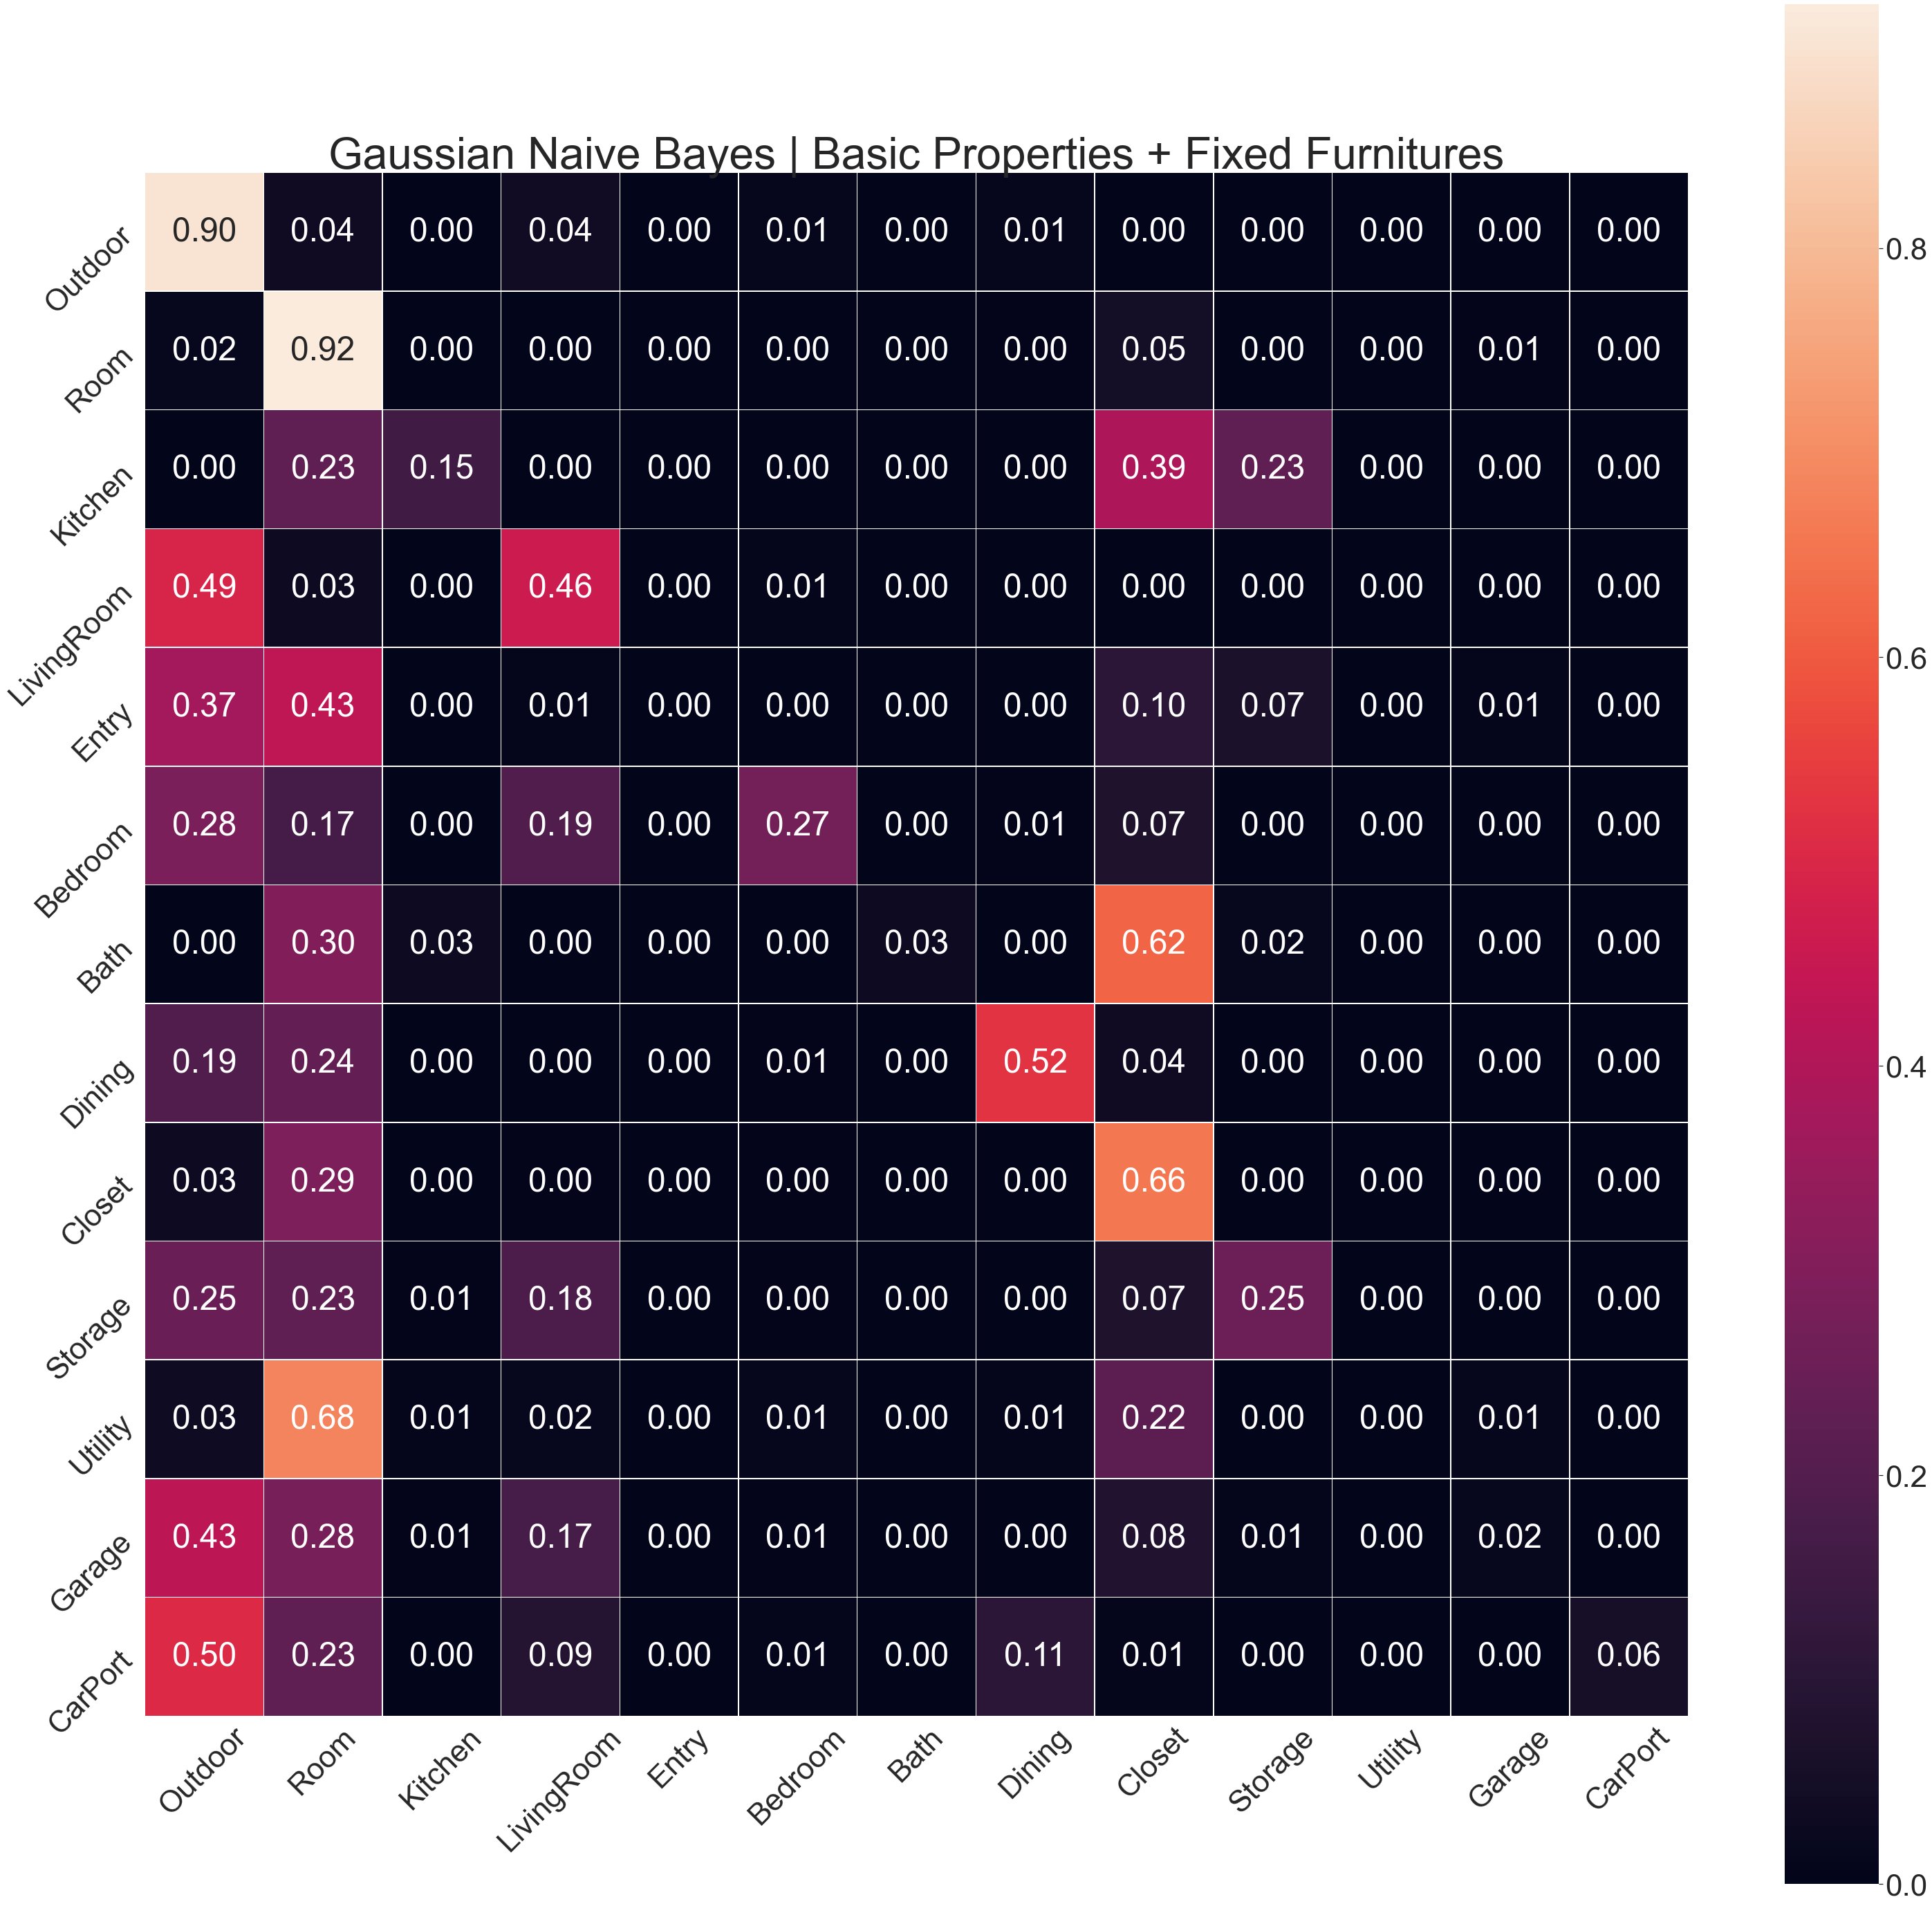

In [25]:
file_name = "GNB_Tier2b_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_test).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f", linewidths=.5, square=True)
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Gaussian Naive Bayes | Basic Properties + Fixed Furnitures', fontsize = 64)
plt.savefig(fig_PATH, dpi=300, bbox_inches = 'tight')
plt.show()

In [16]:
cMat

array([[1964,   80,    0,   87,    0,   25,    0,   25,    1,    0,    0,
           0,    5],
       [  36, 2204,    0,    0,    0,    8,    0,    9,  119,    2,    5,
          15,    0],
       [   0,   19,   13,    0,    0,    0,    0,    0,   33,   19,    0,
           0,    0],
       [ 449,   29,    0,  421,    0,    8,    0,    1,    1,    0,    0,
           3,    0],
       [ 106,  124,    0,    3,    0,    0,    0,    1,   30,   19,    0,
           3,    0],
       [ 517,  300,    0,  350,    0,  492,    0,   12,  136,    5,    0,
           1,    2],
       [   0,   37,    4,    0,    0,    0,    4,    0,   77,    2,    0,
           0,    0],
       [ 264,  322,    0,    4,    0,    8,    0,  715,   49,    0,    2,
           0,    0],
       [  39,  388,    4,    6,    0,    6,    2,    4,  875,    4,    0,
           0,    0],
       [ 592,  533,   12,  435,    0,   11,    0,    2,  171,  599,    0,
           1,    0],
       [  22,  434,    6,   10,    0,    8,    1, 

## Tier 3

In [20]:
##TIER 3
#Train
X_train = X_train_train
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test
y_test = y_test_test['type_cleaned']

#-----Train
gnb = GaussianNB()
GaussianNB()
gnb.fit(X_train,y_train)
print(gnb.get_params())
#-----Train Score       #Mean accuracy of the data and its labels
train_score3 = gnb.score(X_train,y_train) 
print("All Features Training score: ",train_score3)
#-----Predict
pred = gnb.predict(X_test)
# evaluate predictions
accuracy_3 = accuracy_score(y_true =y_test, y_pred= pred)
print("Space Properties and Connectivity Accuracy: %.2f%%" % (accuracy_3 * 100.0))
# Report Classification Results
file_name = "GNB_Tier3_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred))

{'priors': None, 'var_smoothing': 1e-09}
All Features Training score:  0.500516490813842
Space Properties and Connectivity Accuracy: 50.78%
              precision    recall  f1-score   support

        Bath       0.46      0.88      0.60      2187
     Bedroom       0.46      0.93      0.62      2398
     CarPort       0.15      0.12      0.13        84
      Closet       0.30      0.61      0.40       912
      Dining       1.00      0.02      0.03       286
       Entry       0.91      0.29      0.43      1815
      Garage       0.43      0.02      0.05       124
     Kitchen       0.87      0.51      0.64      1364
  LivingRoom       0.57      0.66      0.61      1328
     Outdoor       0.89      0.22      0.36      2356
        Room       0.33      0.00      0.01       635
     Storage       0.60      0.01      0.02       586
     Utility       0.82      0.03      0.06       447

    accuracy                           0.51     14522
   macro avg       0.60      0.33      0.30     

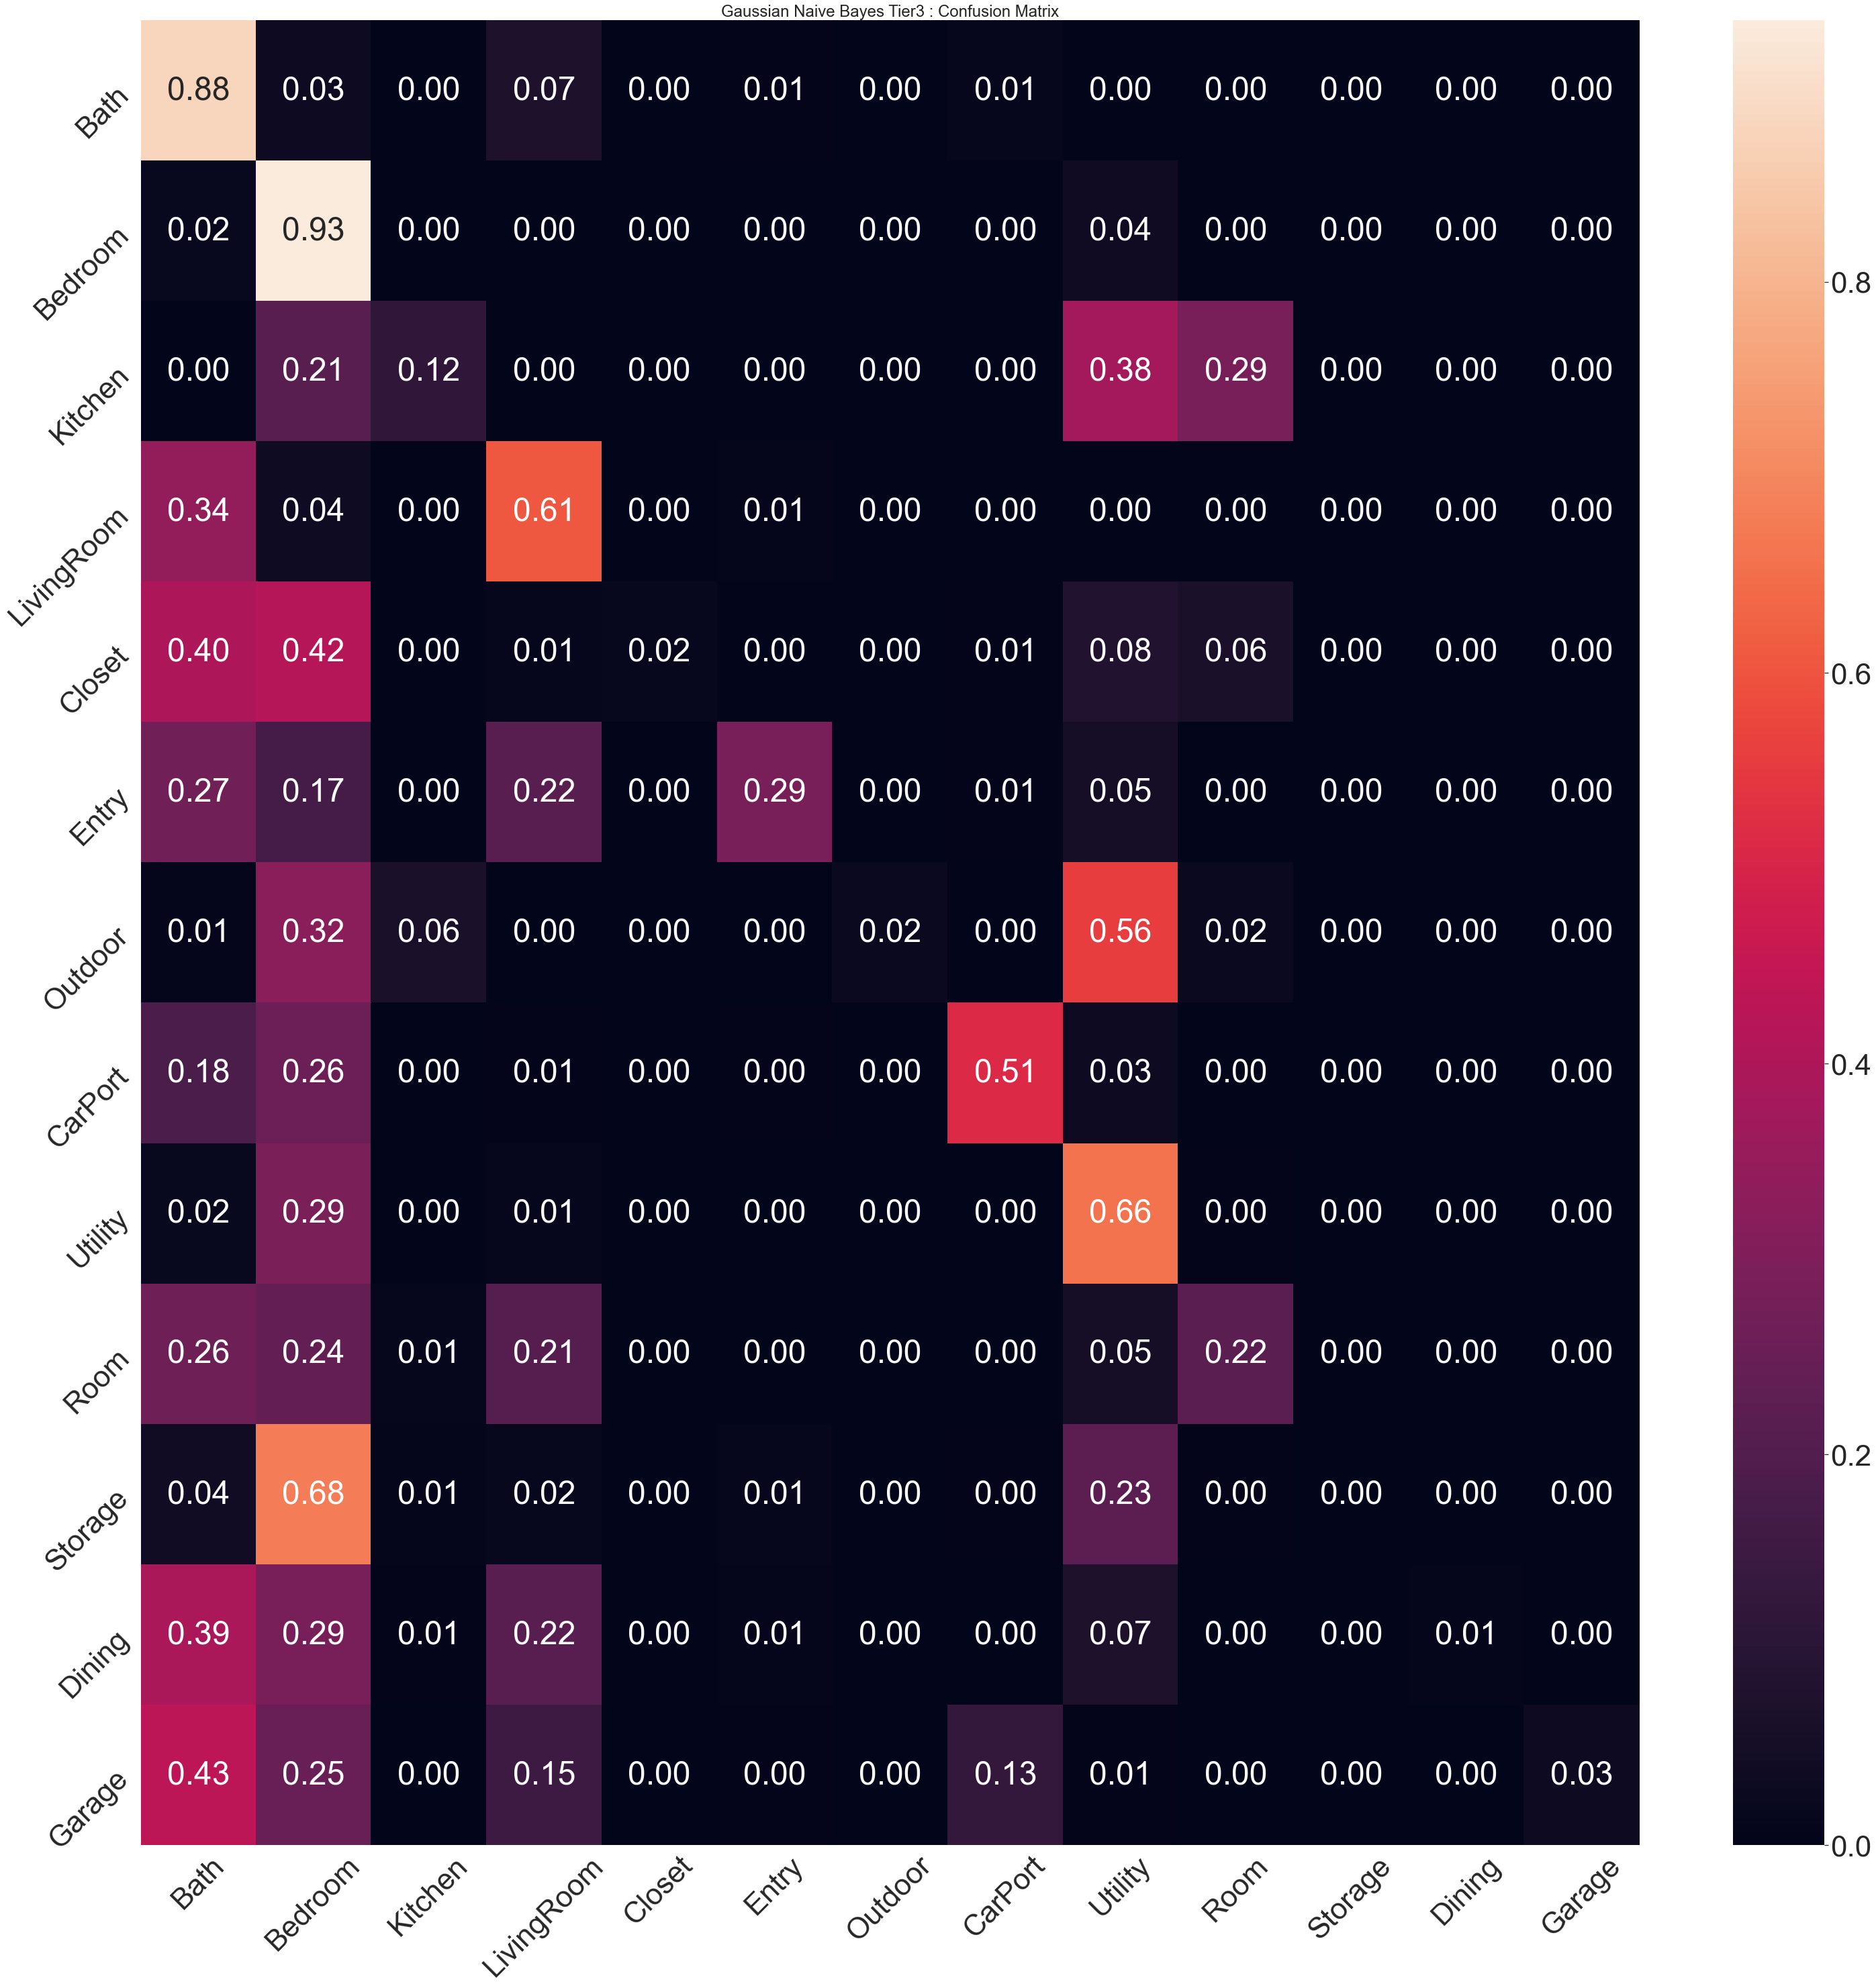

In [21]:
file_name = "GNB_Tier3_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(pred).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Gaussian Naive Bayes Tier3 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=300)
plt.show()

In [30]:
dict1 = (dict(zip(gnb.classes_,gnb.class_count_)))
# dict1_p = (dict(zip(gnb_1.classes_,gnb_1.class_prior_)))
# dict2 = (dict(zip(gnb_2.classes_,gnb_2.class_count_)))
# dict2_p = (dict(zip(gnb_2.classes_,gnb_2.class_prior_)))
# dict3 = (dict(zip(gnb_3.classes_,gnb_3.class_count_)))
# dict3_p = (dict(zip(gnb_3.classes_,gnb_3.class_prior_)))

# fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))
# axes[0,0].bar(x=np.arange(0,len(dict1.keys())),height = dict1.values(), tick_label = dict1.keys())
# axes[1,0].plot(dict1_p.values(), color='r')
# axes[0,0].set_xticklabels(labels= dict1.keys(),rotation = 90)
# axes[1,0].set_xticklabels(labels= dict1.keys(),rotation = 90)

# axes[0,1].bar(x=np.arange(0,len(dict2.keys())),height = dict2.values(), tick_label = dict2.keys())
# axes[1,1].plot(dict2_p.values(), color='r')
# axes[0,1].set_xticklabels(labels= dict1.keys(),rotation = 90)
# axes[1,1].set_xticklabels(labels= dict1.keys(),rotation = 90)

# axes[0,2].bar(x=np.arange(0,len(dict3.keys())),height = dict3.values(), tick_label = dict3.keys())
# axes[1,2].plot(dict3_p.values(), color='r')
# axes[0,2].set_xticklabels(labels= dict1.keys(),rotation = 90)
# axes[1,2].set_xticklabels(labels= dict1.keys(),rotation = 90)

# plt.tight_layout()


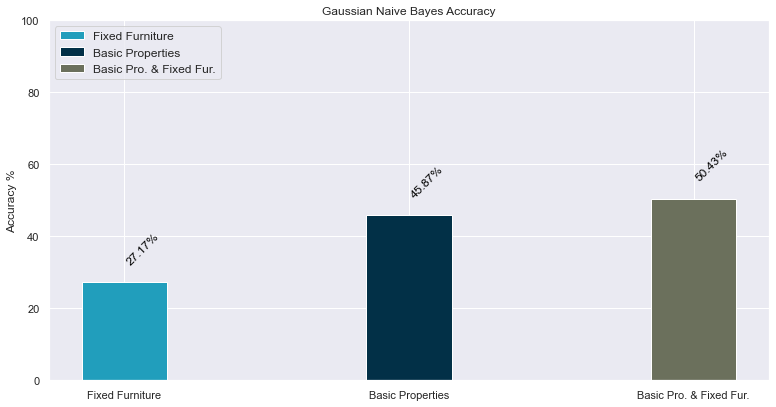

In [50]:
sns.set(font_scale=1)
file_name = "GNB_acu.png"
fig_PATH = join(img_PATH,file_name)
fig1 = plt.figure(figsize=(10,5))
ax = fig1.add_axes([0.1,0.1,1,1])
# ax.bar(x='Space Connectivity', height = accuracy_1a*100,width=0.3, label='Space Connectivity', color='#8ecae6')
ax.bar(x='Fixed Furniture', height = accuracy_1b*100,width=0.3, label='Fixed Furniture', color='#219ebc')
ax.bar(x='Basic Properties', height = accuracy_1c*100,width=0.3, label='Basic Properties', color='#023047')
# ax.bar(x='Space Pro. & Connec.', height = accuracy_2a*100,width=0.3, label='Space Pro. + Connectivity', color='#a5a58d')
ax.bar(x='Basic Pro. & Fixed Fur.', height = accuracy_2b*100,width=0.3, label='Basic Pro. & Fixed Fur.', color='#6b705c')
# ax.bar(x='All features', height = accuracy_3*100,width=0.3, label='All Features', color='#cb997e')
# Values
ax.set_title('Gaussian Naive Bayes Accuracy', fontsize=12)
ax.set_ylim(0,100)
ax.legend(loc=2, fontsize=12)
ax.set_ylabel('Accuracy %', fontsize=12)
# ax.text('Space Connectivity', accuracy_1a*100+5, "%.2f%%" % (accuracy_1a * 100.0), color='black', rotation=45, fontsize=12)
ax.text('Fixed Furniture', accuracy_1b*100+5, "%.2f%%" % (accuracy_1b * 100.0), color='black', rotation=45, fontsize=12)
ax.text('Basic Properties', accuracy_1c*100+5, "%.2f%%" % (accuracy_1c * 100.0), color='black', rotation=45, fontsize=12)
# ax.text('Space Pro. & Connec.', accuracy_2a*100+5, "%.2f%%" % (accuracy_2a * 100.0), color='black', rotation=45, fontsize=12)
ax.text('Basic Pro. & Fixed Fur.', accuracy_2b*100+5, "%.2f%%" % (accuracy_2b * 100.0), color='black', rotation=45, fontsize=12)
# ax.text('All features', accuracy_3*100+5, "%.2f%%" % (accuracy_3 * 100.0), color='black', rotation=45, fontsize=12)
fig1.savefig(fig_PATH,dpi=300, bbox_inches='tight')

FixedFormatter should only be used together with FixedLocator


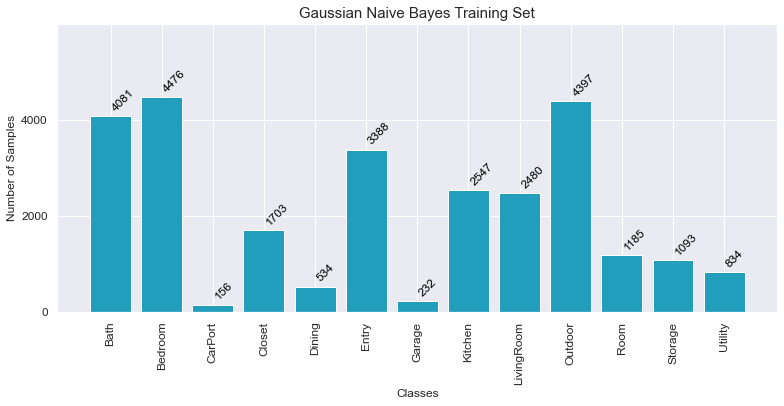

In [47]:
file_name = "GNB_classes.png"
fig_PATH = join(img_PATH,file_name)
fig2 = plt.figure(figsize=(10,8))
ax = fig2.add_axes([0.2,0.2,1,.5])
ax.bar(x=np.arange(0,len(dict1.keys())),height = dict1.values(), tick_label = dict1.keys() ,color="#219ebc")
ax.set_xticklabels(labels= dict1.keys(),rotation = 90, fontsize = 12)
ax.set_yticklabels(labels= [0,2000,4000] ,rotation = 0, fontsize = 12)
ax.set_title('Gaussian Naive Bayes Training Set',fontweight='normal', fontsize=15)
# ax.set_ylim(0,100)
ax.set_ylabel('Number of Samples',fontweight='normal', fontsize= 12)
ax.set_xlabel('Classes',fontweight='normal', fontsize= 12)
ax.set_ylim(0,6000)
for i,val in enumerate(dict1.values()):
    ax.text(x=np.arange(0,len(dict1.keys()))[i],y =val+100,  s= str(int(val)), color='black', fontweight='normal', rotation=45, fontsize=12)

fig2.savefig(fig_PATH,dpi=300, bbox_inches= 'tight')